In [4]:
from plot_quarterly import plot_quarterly

from datetime import datetime
from pylab import rcParams
import pandas as pd
import gzip
import pickle
import numpy as np
import glob
import os

In [2]:
def plot_predictions_from_pickled(results_directory, model_name):
    rcParams['figure.figsize'] = 16, 10
    prediction_samples = np.concatenate(list(pickle.load(gzip.open(f, 'rb'))['y_pred'] 
        for f in glob.glob(os.path.join(results_directory, 'fit*_extract.pkl.gz'))), axis=1)
    sample_size = prediction_samples.shape[0]
    
    def add_date_index(values):
        return pd.Series(values, 
                         index=pd.date_range(start=datetime(2014, 1, 1), end=datetime(2014, 12, 30)))
    
    mean_predictions = add_date_index(prediction_samples.mean(axis=0))
    std_predictions = add_date_index(prediction_samples.std(axis=0))
    ci_95_hw = 1.96 * std_predictions / (sample_size ** 0.5)
    
    births_2000s_df = pd.read_csv('US_births_2000-2014_SSA.csv')
    y_test_2014 = births_2000s_df\
        .rename(columns={'date_of_month': 'day'})\
        .set_index(pd.to_datetime(
            births_2000s_df.rename(columns={'date_of_month': 'day'})
            [['year', 'month', 'day']]))\
        .births[lambda df: df.index >= datetime(2014, 1, 1)]
    
    return plot_quarterly(model_name, mean_predictions, ci_95_hw, y_test_2014)

903.9586757116542

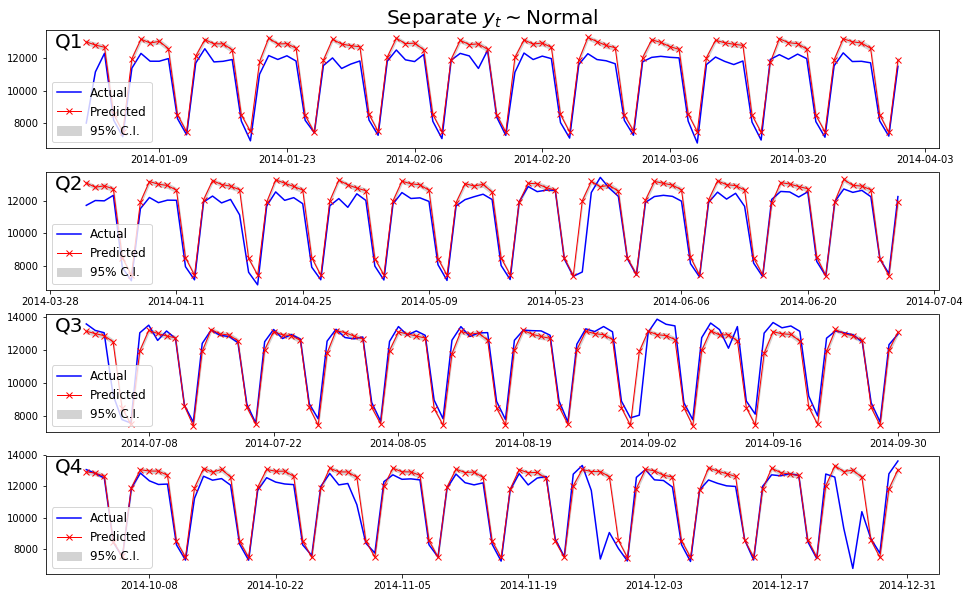

In [9]:
plot_predictions_from_pickled('fit_separate', 'Separate $y_t \sim$Normal')

897.1197308831815

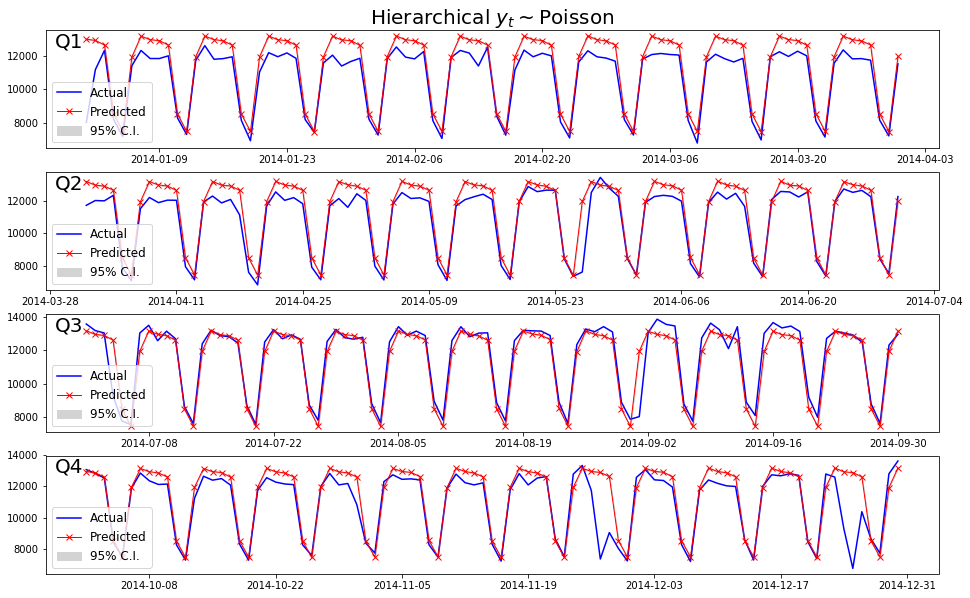

In [13]:
plot_predictions_from_pickled('fit_hier_poisson', 'Hierarchical $y_t \sim$Poisson')

896.8871826563911

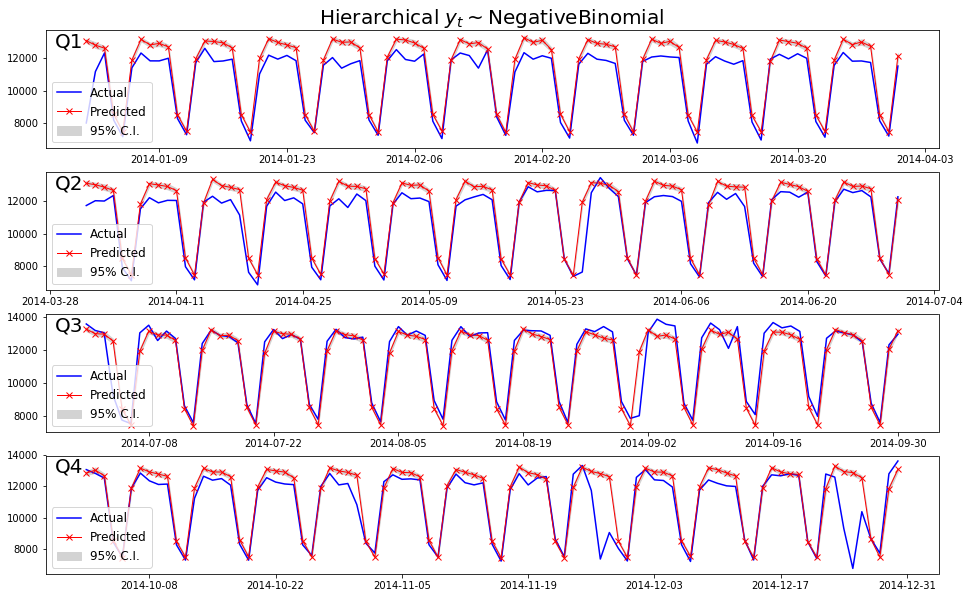

In [21]:
plot_predictions_from_pickled('fit_hier_negbin_one_phi', 'Hierarchical $y_t \sim$NegativeBinomial')